In [2]:
#Import modules.

In [3]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [4]:
import os
from pathlib import Path

archive_path = '/Users/mithilrsh/Desktop/Zidio P2/archive'
print("Contents of archive folder:")
print(os.listdir(archive_path))

Contents of archive folder:
['captions.txt', '.DS_Store', 'Images']


In [5]:
# Modern path handling with Path
base_dir = Path('/Users/mithilrsh/Desktop/Zidio P2')
archive_dir = base_dir / 'archive'
working_dir = base_dir / 'working'

# Expected subdirectories (Flickr8k standard structure)
images_dir = archive_dir / 'Images'
captions_file = archive_dir / 'captions.txt'

# Create working directory
working_dir.mkdir(exist_ok=True, parents=True)

# Verify critical paths
assert images_dir.exists(), f"Images folder missing at {images_dir}"
assert captions_file.exists(), f"Captions file missing at {captions_file}"
print("✓ All paths validated successfully")

✓ All paths validated successfully


In [6]:
#Extract image features

In [7]:
#load VGG16 model
model=VGG16()

model=Model(inputs=model.inputs, outputs=model.layers[-2].output)

#summrize
print(model.summary)

<bound method Model.summary of <Functional name=functional, built=True>>


In [8]:
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

# 1. FIX THESE PATHS
base_dir = '/Users/mithilrsh/Desktop/Zidio P2/archive'  # Added /archive
directory = os.path.join(base_dir, 'Images')

# 2. Add this quick check
if not os.path.exists(directory):
    raise FileNotFoundError(f"Images folder not found at: {directory}\n"
                          f"These folders exist: {os.listdir(base_dir)}")

features = {}

for img_name in tqdm(os.listdir(directory)):
    # Load the image
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224,224))
    
    # Convert to array and reshape
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    # Preprocess and extract features
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    
    # Store features
    image_id = img_name.split('.')[0]
    features[image_id] = feature

100%|████████████████████████████████████| 8091/8091 [12:08:50<00:00,  5.40s/it]


In [9]:
#store features in pickle
WORKING_DIR = '/Users/mithilrsh/Desktop/Zidio P2/working'  # Define the path
os.makedirs(WORKING_DIR, exist_ok=True)  # Create directory if needed

# Then your original line (with fixed extension):
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))


In [10]:
#load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'),'rb') as f:
    features=pickle.load(f)

In [11]:
#load the captions data.

In [12]:
with open(os.path.join(base_dir, 'captions.txt'), 'r')as f:
    next(f)
    captions_doc=f.read()

In [13]:
captions_doc

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1002674143_1b742ab4b8.j

In [14]:
#create mapping of image to captions
mapping= {}
#process lines
for line in tqdm(captions_doc.split('\n')):
    #split the line by coma(,)
    tokens=line.split(',')
    if len(line)<2:
        continue
    image_id , caption=tokens[0], tokens[1:]
    #remove extension from image ID
    image_id= image_id.split('.')[0]
    #convert caption list to string
    caption=" ".join(caption)
    #create list if needed
    if image_id not in mapping:
        mapping[image_id]=[]
    mapping[image_id].append(caption)

100%|████████████████████████████████| 40456/40456 [00:00<00:00, 1478657.00it/s]


In [15]:
len(mapping)

8091

In [74]:
#preprocess text data

In [112]:
import re

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()

            # Remove any existing start/end tags
            caption = re.sub(r'<start>|<end>|startseq|endseq', '', caption)

            # Remove unwanted characters, keep letters, numbers, apostrophes
            caption = re.sub(r"[^a-zA-Z0-9\s']+", '', caption)

            # Remove extra spaces
            caption = re.sub(r'\s+', ' ', caption).strip()

            # Add correct start/end tags
            caption = 'startseq ' + caption + ' endseq'

            captions[i] = caption


In [114]:
#before preprocess of text 
mapping['3637013_c675de7705']

["startseq startseqstartseqcouple stands close at the water 's edgeendseqendseq endseq",
 'startseq startseqstartseqthe two people stand by body of water and in front of bushes in fallendseqendseq endseq',
 'startseq startseqstartseqtwo people hold each other near pondendseqendseq endseq',
 'startseq startseqstartseqtwo people stand by the waterendseqendseq endseq',
 'startseq startseqstartseqtwo people stand together on the edge of the water on the grassendseqendseq endseq']

In [116]:
#preprocess the text
clean(mapping)

In [118]:
#after preprocess of text
mapping['3637013_c675de7705']

["startseq couple stands close at the water 's edge endseq",
 'startseq the two people stand by body of water and in front of bushes in fall endseq',
 'startseq two people hold each other near pond endseq',
 'startseq two people stand by the water endseq',
 'startseq two people stand together on the edge of the water on the grass endseq']

In [120]:
all_captions=[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
        

In [122]:
len(all_captions)

40455

In [124]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
#tokenize the text
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [25]:
vocab_size

8483

In [26]:
#get maximum length of the caption available
max_length=max(len(caption.split()) for caption in all_captions)
max_length

33

 #train test split

In [28]:
image_ids=list(mapping.keys())
split=int(len(image_ids) * 0.90)
train=image_ids[:split]
test=image_ids[split:]

In [126]:
#startseq couple stands close at the water 's edge endseq
#       X              Y
#<start>               girl
#<start girl           going
#<start> girl going    into
#.................
#startseq couple stands close at the water's edge endseq

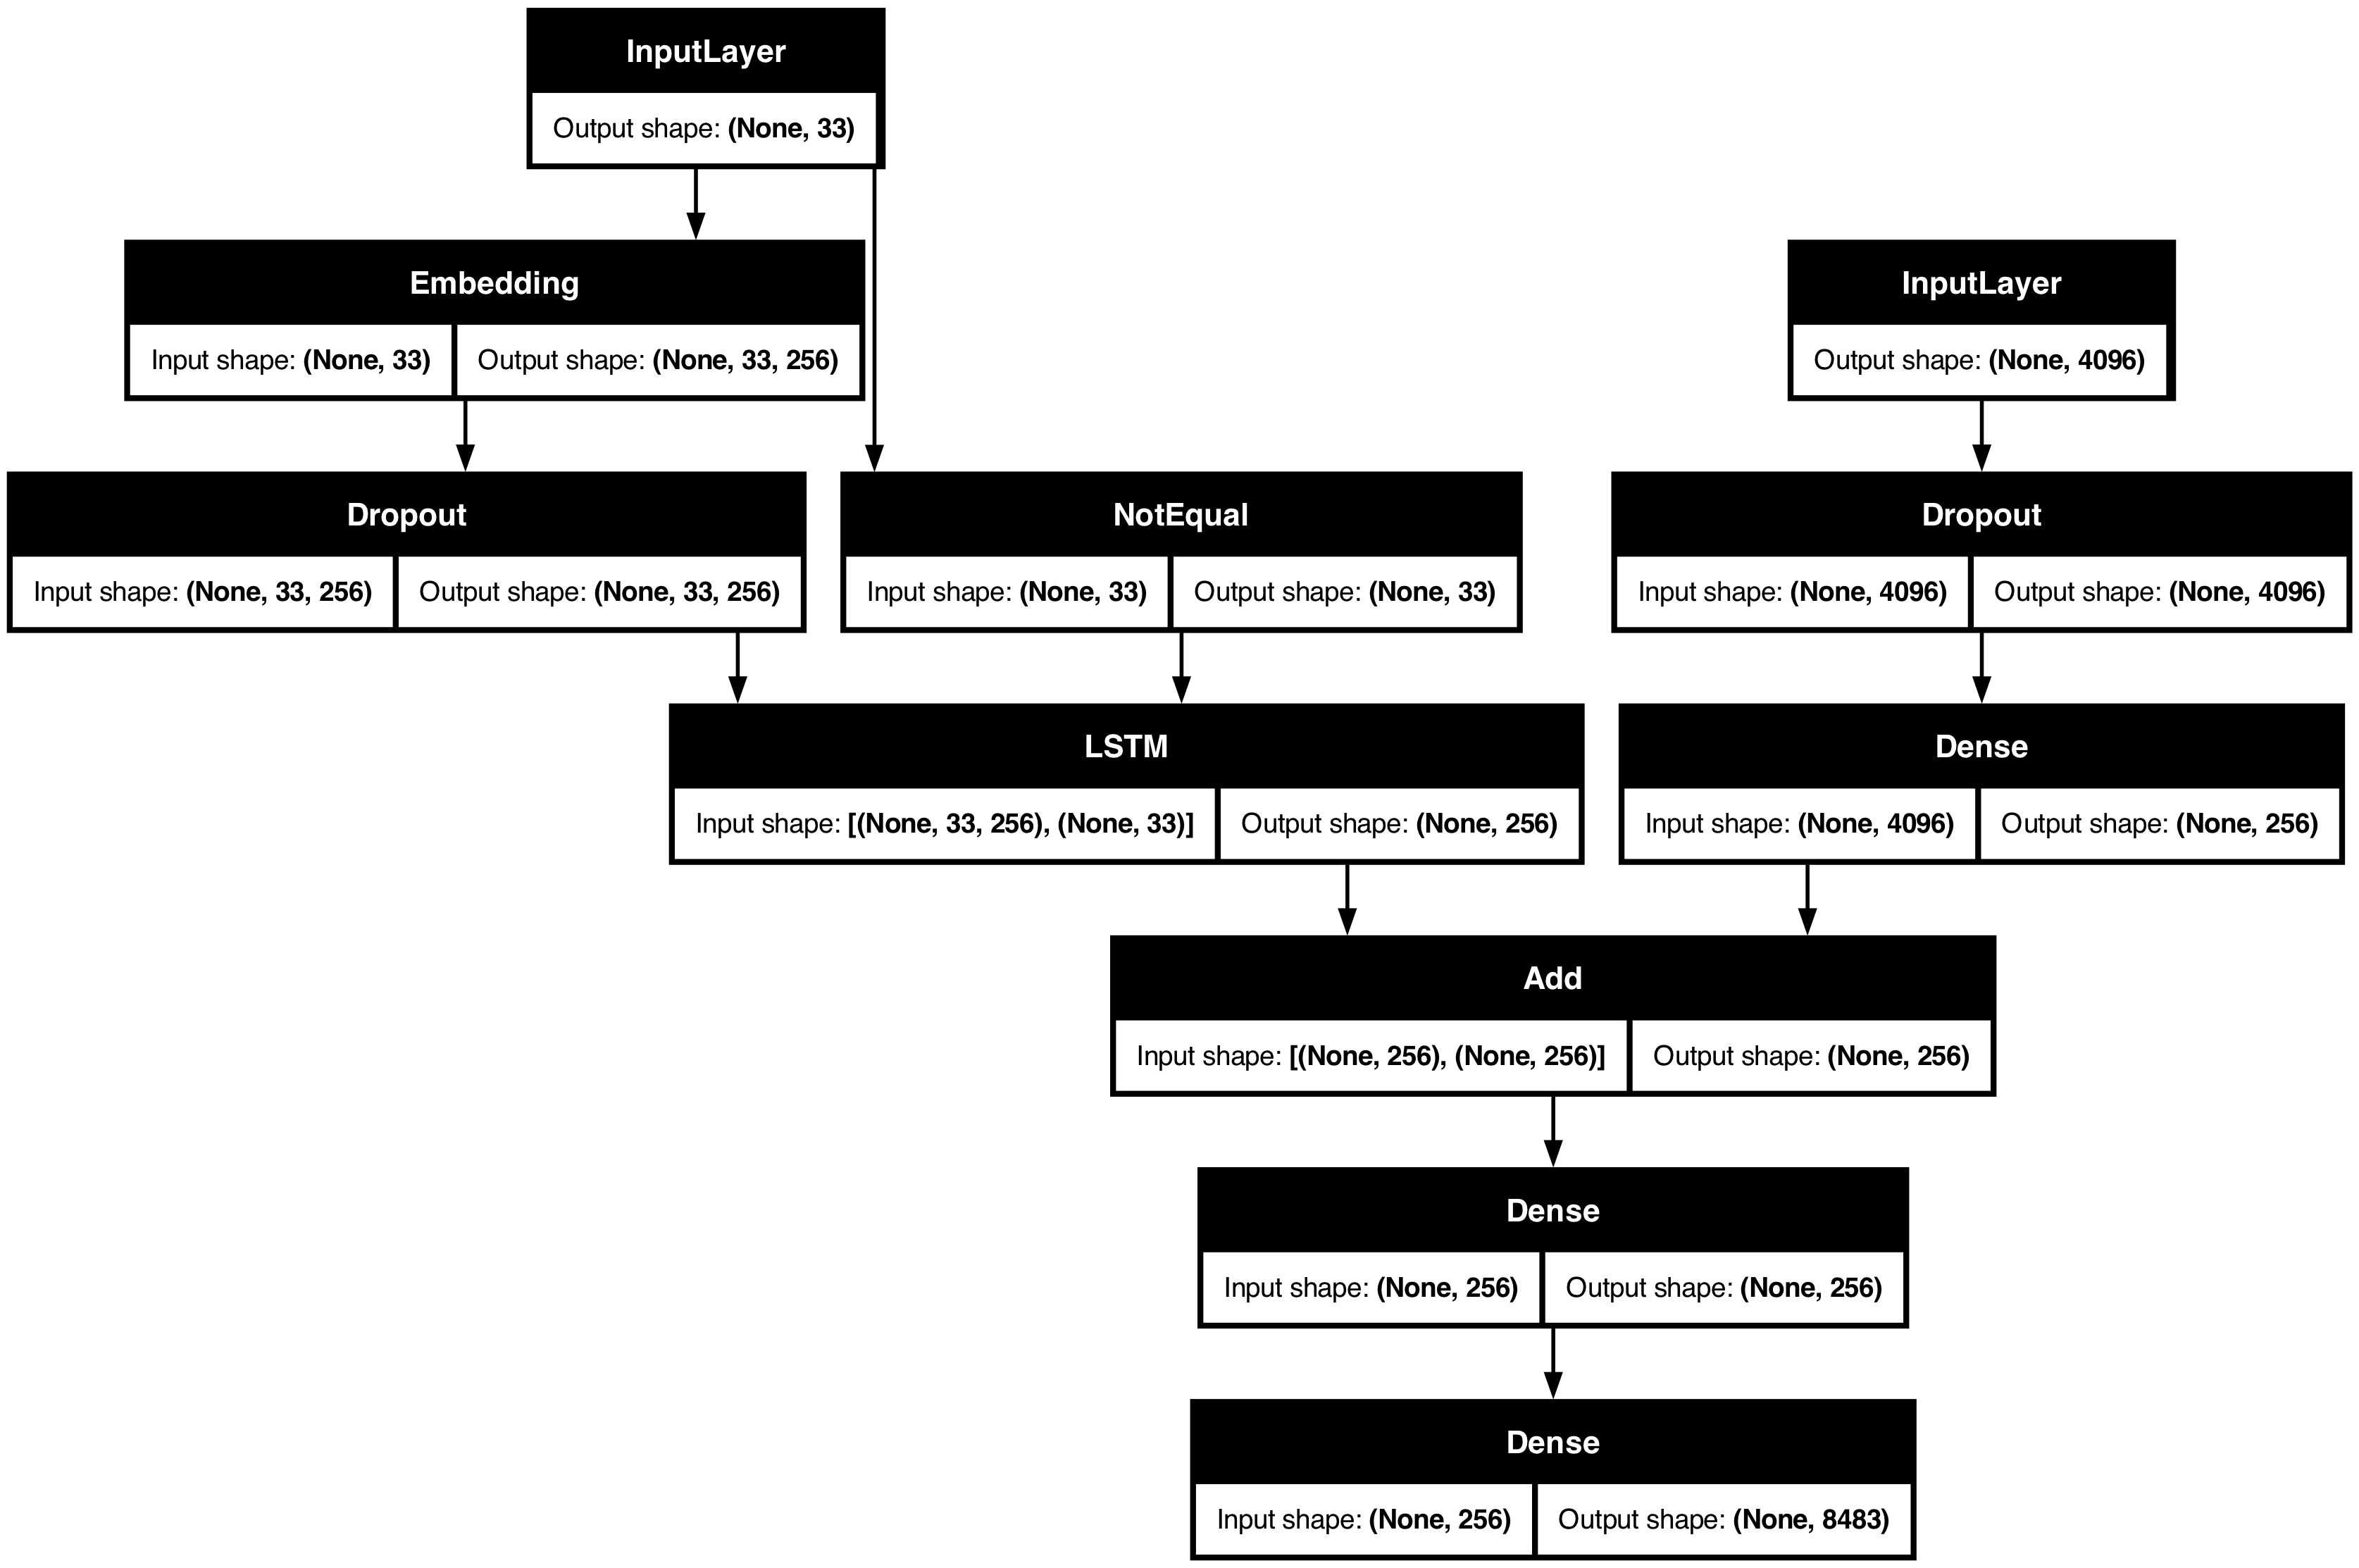

In [128]:
#Encoder model
#image feature layers
inputs1=Input(shape=(4096,))
fe1=Dropout(0.4)(inputs1)
fe2=Dense(256,activation='relu')(fe1)
#sequence feature layer
inputs2=Input(shape=(max_length,))
se1=Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2=Dropout(0.4)(se1)
se3=LSTM(256)(se2)

#Decoder model
decoder1=add([fe2,se3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')

#plot the model
plot_model(model,show_shapes=True)

##Model creation

In [132]:
#create data generator to get data in batch(avoid session crash)
def data_generator(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
    #loop over images
    X1,X2,y=list(),list(),list()
    n=0
    while 1:
        for key in data_keys:
            n +=1
            captions=mapping[key]
            #process each caption
            for caption in captions:
                #encode the sequence
                seq=tokenizer.texts_to_sequences([caption])[0]
                #split the sequence into x,y pairs
                for i in range(1,len(seq)):
                    #split into input and output pairs
                    in_seq, out_seq=seq[:i], seq[i]
                    #pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    #encode output sequence
                    out_seq=to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    #store the sequence
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==batch_size:
                X1,X2,y=np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y 
                X1,X2,y=list(),list(),list()
                n=0

In [134]:
import tensorflow as tf

# Get feature dimension (usually 4096 for VGG16)
feature_dim = features[list(features.keys())[0]][0].shape[0]

# Define a function to return your generator (required by tf.data)

def tf_data_generator():
    return data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

output_signature = (
    (
        tf.TensorSpec(shape=(None, feature_dim), dtype=tf.float32),
        tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)
    ),
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
)

dataset = tf.data.Dataset.from_generator(
    tf_data_generator,
    output_signature=output_signature
)


In [136]:
X1_dummy = tf.random.normal((1, feature_dim))
X2_dummy = tf.zeros((1, max_length), dtype=tf.int32)
_ = model([X1_dummy, X2_dummy])


In [138]:
epochs = 20
# Define batch size and number of steps
batch_size = 64  # or 32 depending on memory
steps = len(train) // batch_size

model.fit(dataset, epochs=epochs, steps_per_epoch=steps, verbose=1)


Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - loss: 6.4716
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - loss: 4.8006
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - loss: 4.0452
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - loss: 3.7022
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - loss: 3.4582
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - loss: 3.2779
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - loss: 3.1322
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - loss: 3.0068
Epoch 9/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 2065s 18s/step - loss: 2.9087
Epoch 10/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - loss: 2.8339
Epoch 11/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - loss: 2.7666
Epoch 12/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - loss: 2.6947
Epoch 13/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - loss: 2.6228
Epoch 14/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - loss: 2.5676
Epoch 15/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 

In [140]:
#save the model.
model.save(WORKING_DIR+'/best_model.h5')

In [141]:
#generate captions for the image

In [142]:
def idx_to_word(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [143]:
#generate caption for an image
def predict_caption(model,image,tokenizer,max_length):
    #add start tag for generation process
    in_text='startseq'
    #iterate over the max length of sequence
    for i in range(max_length):
        #encode input sequence
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        #pad the sequence
        sequence=pad_sequences([sequence],max_length)
        #predict next word
        yhat=model.predict([image,sequence],verbose=0)
        #ger index with high probability
        yhat=np.argmax(yhat)
        #convert index to word
        word=idx_to_word(yhat, tokenizer)
        #stop if word ot found
        if word is None:
            break
        #append word as input for generating next word
        in_text+=" "+word
        #stop if we reach and tag
        if word=='endseq':
            break
    return in_text

In [144]:
from nltk.translate.bleu_score import corpus_bleu
#validate with test data
actual, predicted =list(),list()

for key in tqdm(test):
    #get actual caption
    captions=mapping[key]
    #predict the caption for image
    y_pred=predict_caption(model,features[key],tokenizer,max_length)
    #split into words
    actual_captions=[caption.split() for caption in captions]
    y_pred=y_pred.split()
    #append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

#calculate BLEU score
import sacrebleu

# Flatten references for sacrebleu
# Convert token lists to strings
flattened_predictions = [' '.join(p) for p in predicted]

# Convert list of tokenized references to list of reference strings
flattened_references = [[' '.join(ref) for ref in refs] for refs in actual]

# Transpose references list (sacrebleu expects: List[List[str]], where each inner list contains one reference per prediction)
flattened_references = list(map(list, zip(*flattened_references)))

# Now calculate BLEU
bleu = sacrebleu.corpus_bleu(flattened_predictions, flattened_references)

# Print result
print(f"SacreBLEU score: {bleu.score:.2f}")

100%|█████████████████████████████████████████| 810/810 [33:22<00:00,  2.47s/it]

SacreBLEU score: 3.82


In [145]:
from PIL import Image  # Fixed typo: 'PTL' → 'PIL'
import matplotlib.pyplot as plt
import os

def generate_caption(image_name):
    # Load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(base_dir, "Images", image_name)
    
    image = Image.open(img_path)
    captions = mapping[image_id]
    
    print('-------------Actual-------------')
    for caption in captions:
        print(caption)
    
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    
    print('-------------Predicted-------------')
    print(y_pred)
    
    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()


-------------Actual-------------
startseq blonde horse and blonde girl in black sweatshirt are staring at fire in barrel endseq
startseq girl and her horse stand by fire endseq
startseq girl holding horse 's lead behind fire endseq
startseq a man and girl and two horses are near contained fire endseq
startseq two people and two horses watching fire endseq
-------------Predicted-------------
startseq pony pony and pony pony with draft horse 's mouth open around the other while two people watch nearby display of them watches nearby view of each other while two other people watch


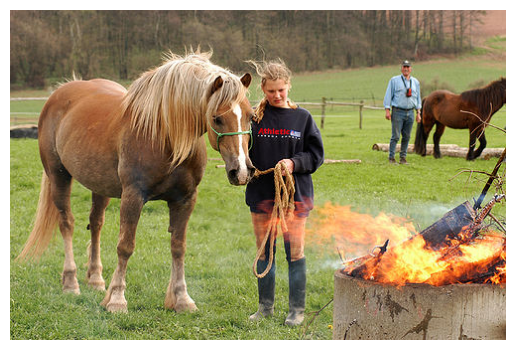

In [146]:
generate_caption("10815824_2997e03d76.jpg")

-------------Actual-------------
startseq children sit and watch the fish moving in the pond endseq
startseq people stare at the orange fish endseq
startseq several people are standing near fish pond endseq
startseq some children watching fish in pool endseq
startseq there are several people and children looking into water with blue tiled floor and goldfish endseq
-------------Predicted-------------
startseq person is sitting on bench with his hand on his back and checks her skateboard in skate park skate park deck with graffiti behind him cart behind him and graffiti nearby structure and


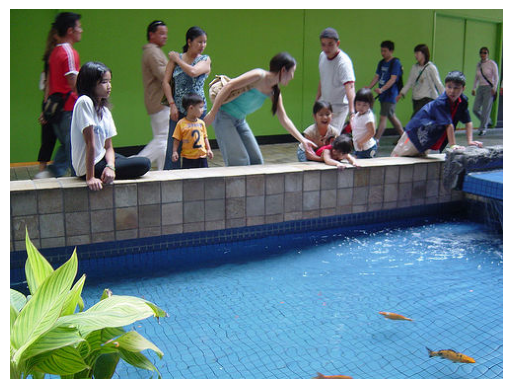

In [147]:
generate_caption("12830823_87d2654e31.jpg")